In [20]:
import pandas as pd

# Load the datasets
train_df = pd.read_csv(r'C:\Users\dell\Downloads\archive (3)\train.csv')
test_df = pd.read_csv(r'C:\Users\dell\Downloads\archive (3)\test.csv')
original = pd.read_csv(r'C:\Users\dell\Downloads\archive (3)\train_dataset_Original.csv')

# Drop the 'id' column
train_df.drop(columns=['id'], inplace=True)
test_df.drop(columns=['id'], inplace=True)


# Display binformation about the datasets
print("Training Dataset Info:")
print(train_df.info())

print("\nTraining Dataset Description:")
print(train_df.describe())

print("\nTest Dataset Info:")
print(test_df.info())

print("\nTest Dataset Description:")
print(test_df.describe())

# Display the first few rows of the training dataset
print("\nFirst Few Rows of Training Dataset:")
print(train_df.head())

# Display the first few rows of the test dataset
print("\nFirst Few Rows of Test Dataset:")
print(test_df.head())


Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  

In [37]:
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from interpret.glassbox import ExplainableBoostingClassifier
from tpot import TPOTClassifier

# Load datasets
train_df = pd.read_csv(r'C:\Users\dell\Downloads\archive (3)\train.csv')
test_df = pd.read_csv(r'C:\Users\dell\Downloads\archive (3)\test.csv')



class Xformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X, y=None, **params):
        return self

    @staticmethod
    def _reduce_mem(df):
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2
        for col in df.columns:
            col_type = df[col].dtype
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if 'int' in str(col_type):
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory reduced from {start_mem:.2f} MB to {end_mem:.2f} MB")
        return df

    def transform(self, X, y=None, **params):
        df = X.copy()
        df['hearing(left)'] = (df['hearing(left)'] - 1).astype(np.uint8)
        df['hearing(right)'] = (df['hearing(right)'] - 1).astype(np.uint8)
        df['age'] = np.uint8(np.around(df['age'] / 5, 0) * 5)
        df['age_risk'] = np.where(df['age'] >= 45, 1, 0).astype(np.uint8)
        df['BMR'] = (df['weight(kg)'] / ((df['height(cm)']/100)**2)).astype(np.float32)
        df['BMR_risk'] = np.select([df['BMR'] < 18.5, df['BMR'] < 25, df['BMR'] < 30, df['BMR'] < 35, df['BMR'] < 40], [0,1,2,3,4], 5).astype(np.uint8)
        df['obesity_risk'] = np.select([df['waist(cm)'] < 80, df['waist(cm)'].between(80,88, inclusive="both")], [0,1], 2).astype(np.uint8)
        df['BP_risk'] = np.select([(df['systolic'] < 120) | (df['relaxation'] < 80), 
                                   (df['systolic'] < 130) | (df['relaxation'] < 85), 
                                   (df['systolic'] < 140) | (df['relaxation'] < 90), 
                                   (df['systolic'] < 180) | (df['relaxation'] < 120)], [0,1,2,3], 4).astype(np.uint8)
        df['tot_chol_risk'] = np.where(df['Cholesterol'] >= 200, 1, 0).astype(np.uint8)
        df['HDL_risk'] = np.select([df['HDL'] >= 60, df['HDL'] >= 40], [0,1], 2).astype(np.uint8)
        df['LDL_risk'] = np.select([df['LDL'] < 100, df['LDL'] < 130, df['LDL'] < 160, df['LDL'] < 190], [0,1,2,3], 4).astype(np.uint8)
        df['tglyd_risk'] = np.select([df['triglyceride'] < 150, df['triglyceride'] < 200, df['triglyceride'] < 500], [0,1,2], 3).astype(np.uint8)
        df['hemoglobin_risk'] = np.where(df['hemoglobin'].between(13.8, 17.2, inclusive="left"), 0, 1).astype(np.uint8)
        df['creatinine_risk'] = np.where(df['serum creatinine'].between(0.74, 1.35, inclusive="left"), 1, 0).astype(np.uint8)
        df['Gtp_risk'] = np.where(df['Gtp'].between(5, 40, inclusive="left"), 1, 0).astype(np.uint8)
        df['AST_risk'] = np.where(df['AST'].between(8, 45, inclusive="left"), 1, 0).astype(np.uint8)
        df['ALT_risk'] = np.where(df['ALT'].between(8, 45, inclusive="left"), 1, 0).astype(np.uint8)
        df = self._reduce_mem(df)
        return df

    def fit_transform(self, X, y=None, **params):
        self.fit(X, y, **params)
        return self.transform(X, y, **params)

















In [38]:
# Preprocess the data


from sklearn.preprocessing import StandardScaler


def preprocess_data(df, is_train=True):
    if is_train:
        X = df.drop(columns=['smoking', 'id'])
        y = df['smoking']
    else:
        X = df.drop(columns=['id'])
        y = None

    transformer = Xformer()
    if is_train:
        X = transformer.fit_transform(X)
    else:
        X = transformer.transform(X)

    return X, y

X_train_full, y_train_full = preprocess_data(train_df, is_train=True)
X_test, _ = preprocess_data(test_df, is_train=False)

# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data
X_train_scaled = scaler.fit_transform(X_train)


X_val_scaled = scaler.transform(X_val)

model_performance = {}





Memory reduced from 26.12 MB to 8.20 MB
Memory reduced from 17.42 MB to 5.47 MB


In [39]:
import pandas as pd


train_df = pd.read_csv(r'C:\Users\dell\Downloads\archive (3)\train.csv')
test_df = pd.read_csv(r'C:\Users\dell\Downloads\archive (3)\test.csv')

# Display the columns of the new datasets to identify the correct column names
print("Training dataset columns:", train_df.columns)
print("Testing dataset columns:", test_df.columns)


Training dataset columns: Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')
Testing dataset columns: Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries'],
      dtype='object')


In [40]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Initialize and train the KNN model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_knn = knn_model.predict(X_val_scaled)
y_proba_knn = knn_model.predict_proba(X_val_scaled)[:, 1]

 
model_performance['KNN'] = {
    'Accuracy': accuracy_score(y_val, y_pred_knn),
    'F1 Score': f1_score(y_val, y_pred_knn),
    'ROC AUC': roc_auc_score(y_val, y_proba_knn)
}

print(f"KNN - Accuracy: {model_performance['KNN']['Accuracy']}, F1 Score: {model_performance['KNN']['F1 Score']}, ROC AUC: {model_performance['KNN']['ROC AUC']}")


KNN - Accuracy: 0.722215245510486, F1 Score: 0.6934589800443459, ROC AUC: 0.7928620486621102


In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Initialize the model
knn = KNeighborsClassifier()

# Perform Grid Search
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)

# Best parameters and performance
print(f"Best parameters for KNN: {grid_search_knn.best_params_}")
print(f"Best score for KNN: {grid_search_knn.best_score_}")

# Evaluate on validation set
knn_best = grid_search_knn.best_estimator_
y_pred_knn = knn_best.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_knn)
f1 = f1_score(y_val, y_pred_knn)
roc_auc = roc_auc_score(y_val, knn_best.predict_proba(X_val)[:, 1])
print(f"Validation Accuracy for KNN: {accuracy}")
print(f"Validation F1 Score for KNN: {f1}")
print(f"Validation ROC AUC for KNN: {roc_auc}")


Best parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
Best score for KNN: 0.7371275688716135
Validation Accuracy for KNN: 0.7347733266356901
Validation F1 Score for KNN: 0.7114951164537942
Validation ROC AUC for KNN: 0.8095107644349246


In [41]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_logistic = logistic_model.predict(X_val_scaled)
y_proba_logistic = logistic_model.predict_proba(X_val_scaled)[:, 1]

 
model_performance['Logistic Regression'] = {
    'Accuracy': accuracy_score(y_val, y_pred_logistic),
    'F1 Score': f1_score(y_val, y_pred_logistic),
    'ROC AUC': roc_auc_score(y_val, y_proba_logistic)
}

print(f"Logistic Regression - Accuracy: {model_performance['Logistic Regression']['Accuracy']}, F1 Score: {model_performance['Logistic Regression']['F1 Score']}, ROC AUC: {model_performance['Logistic Regression']['ROC AUC']}")


Logistic Regression - Accuracy: 0.750251161622504, F1 Score: 0.7268106734434562, ROC AUC: 0.8350167531528071


In [42]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_gb = gb_model.predict(X_val_scaled)
y_proba_gb = gb_model.predict_proba(X_val_scaled)[:, 1]

 
model_performance['Gradient Boosting'] = {
    'Accuracy': accuracy_score(y_val, y_pred_gb),
    'F1 Score': f1_score(y_val, y_pred_gb),
    'ROC AUC': roc_auc_score(y_val, y_proba_gb)
}

print(f"Gradient Boosting - Accuracy: {model_performance['Gradient Boosting']['Accuracy']}, F1 Score: {model_performance['Gradient Boosting']['F1 Score']}, ROC AUC: {model_performance['Gradient Boosting']['ROC AUC']}")


Gradient Boosting - Accuracy: 0.7724161748084892, F1 Score: 0.7590173199029288, ROC AUC: 0.8561303410001271


In [43]:
import xgboost as xgb

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_val_scaled)
y_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]

 
model_performance['XGBoost'] = {
    'Accuracy': accuracy_score(y_val, y_pred_xgb),
    'F1 Score': f1_score(y_val, y_pred_xgb),
    'ROC AUC': roc_auc_score(y_val, y_proba_xgb)
}

print(f"XGBoost - Accuracy: {model_performance['XGBoost']['Accuracy']}, F1 Score: {model_performance['XGBoost']['F1 Score']}, ROC AUC: {model_performance['XGBoost']['ROC AUC']}")


XGBoost - Accuracy: 0.7790091673992214, F1 Score: 0.7624287016099092, ROC AUC: 0.8612935190798756


In [44]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_rf = random_forest_model.predict(X_val_scaled)
y_proba_rf = random_forest_model.predict_proba(X_val_scaled)[:, 1]

 
model_performance['Random Forest'] = {
    'Accuracy': accuracy_score(y_val, y_pred_rf),
    'F1 Score': f1_score(y_val, y_pred_rf),
    'ROC AUC': roc_auc_score(y_val, y_proba_rf)
}

print(f"Random Forest - Accuracy: {model_performance['Random Forest']['Accuracy']}, F1 Score: {model_performance['Random Forest']['F1 Score']}, ROC AUC: {model_performance['Random Forest']['ROC AUC']}")


Random Forest - Accuracy: 0.7699359537862615, F1 Score: 0.7538792234835763, ROC AUC: 0.8531861011634216


In [45]:
from catboost import CatBoostClassifier

# Initialize and train the CatBoost model
catboost_model = CatBoostClassifier(verbose=0)
catboost_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_cb = catboost_model.predict(X_val_scaled)
y_proba_cb = catboost_model.predict_proba(X_val_scaled)[:, 1]

 
model_performance['CatBoost'] = {
    'Accuracy': accuracy_score(y_val, y_pred_cb),
    'F1 Score': f1_score(y_val, y_pred_cb),
    'ROC AUC': roc_auc_score(y_val, y_proba_cb)
}

print(f"CatBoost - Accuracy: {model_performance['CatBoost']['Accuracy']}, F1 Score: {model_performance['CatBoost']['F1 Score']}, ROC AUC: {model_performance['CatBoost']['ROC AUC']}")


CatBoost - Accuracy: 0.781018460379254, F1 Score: 0.7650961506078874, ROC AUC: 0.8650602730070971


In [46]:
from sklearn.neural_network import MLPClassifier

# Initialize and train the MLP model
mlp_model = MLPClassifier(max_iter=1000)
mlp_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_mlp = mlp_model.predict(X_val_scaled)
y_proba_mlp = mlp_model.predict_proba(X_val_scaled)[:, 1]

 
model_performance['MLP Neural Network'] = {
    'Accuracy': accuracy_score(y_val, y_pred_mlp),
    'F1 Score': f1_score(y_val, y_pred_mlp),
    'ROC AUC': roc_auc_score(y_val, y_proba_mlp)
}

print(f"MLP Neural Network - Accuracy: {model_performance['MLP Neural Network']['Accuracy']}, F1 Score: {model_performance['MLP Neural Network']['F1 Score']}, ROC AUC: {model_performance['MLP Neural Network']['ROC AUC']}")


MLP Neural Network - Accuracy: 0.7640336556574155, F1 Score: 0.7392269793907432, ROC AUC: 0.8502559866464487


In [47]:
import lightgbm as lgb

# Initialize and train the LightGBM model
lgbm_model = lgb.LGBMClassifier()
lgbm_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_lgb = lgbm_model.predict(X_val_scaled)
y_proba_lgb = lgbm_model.predict_proba(X_val_scaled)[:, 1]

 
model_performance['LightGBM'] = {
    'Accuracy': accuracy_score(y_val, y_pred_lgb),
    'F1 Score': f1_score(y_val, y_pred_lgb),
    'ROC AUC': roc_auc_score(y_val, y_proba_lgb)
}

print(f"LightGBM - Accuracy: {model_performance['LightGBM']['Accuracy']}, F1 Score: {model_performance['LightGBM']['F1 Score']}, ROC AUC: {model_performance['LightGBM']['ROC AUC']}")


[LightGBM] [Info] Number of positive: 55584, number of negative: 71820
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2335
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436281 -> initscore=-0.256268
[LightGBM] [Info] Start training from score -0.256268
LightGBM - Accuracy: 0.7774080120557579, F1 Score: 0.7621124681250839, ROC AUC: 0.8617697809744469


In [28]:
from tpot import TPOTClassifier

# Initialize and train the TPOT classifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Evaluate the model
y_pred = tpot.predict(X_val)
y_proba = tpot.predict_proba(X_val)[:, 1]
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba)

print(f"TPOT AutoML - Accuracy: {accuracy}, F1 Score: {f1}, ROC AUC: {roc_auc}")


Optimization Progress:   0%|          | 0/300 [00:01<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.7801011043596555

Generation 2 - Current best internal CV score: 0.7802345475870007

Generation 3 - Current best internal CV score: 0.7802345475870007

Generation 4 - Current best internal CV score: 0.7802345475870007

Generation 5 - Current best internal CV score: 0.7802737912824139

Best pipeline: BernoulliNB(XGBClassifier(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=12, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0), alpha=100.0, fit_prior=False)
TPOT AutoML - Accuracy: 0.7767487127966847, F1 Score: 0.7601928978518194, ROC AUC: 0.7825319693177432


In [48]:
from interpret.glassbox import ExplainableBoostingClassifier

# Initialize and train the EBM
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred_ebm = ebm.predict(X_val_scaled)
y_proba_ebm = ebm.predict_proba(X_val_scaled)[:, 1]

 
model_performance['Explainable Boosting Machine'] = {
    'Accuracy': accuracy_score(y_val, y_pred_ebm),
    'F1 Score': f1_score(y_val, y_pred_ebm),
    'ROC AUC': roc_auc_score(y_val, y_proba_ebm)
}

print(f"Explainable Boosting Machine - Accuracy: {model_performance['Explainable Boosting Machine']['Accuracy']}, F1 Score: {model_performance['Explainable Boosting Machine']['F1 Score']}, ROC AUC: {model_performance['Explainable Boosting Machine']['ROC AUC']}")


Explainable Boosting Machine - Accuracy: 0.7844405374858722, F1 Score: 0.767868010007438, ROC AUC: 0.8672827725574073


In [49]:
# Compile results into a DataFrame
results = pd.DataFrame(model_performance).T
print(results)


                              Accuracy  F1 Score   ROC AUC
KNN                           0.722215  0.693459  0.792862
Logistic Regression           0.750251  0.726811  0.835017
Gradient Boosting             0.772416  0.759017  0.856130
XGBoost                       0.779009  0.762429  0.861294
Random Forest                 0.769936  0.753879  0.853186
CatBoost                      0.781018  0.765096  0.865060
MLP Neural Network            0.764034  0.739227  0.850256
LightGBM                      0.777408  0.762112  0.861770
Explainable Boosting Machine  0.784441  0.767868  0.867283


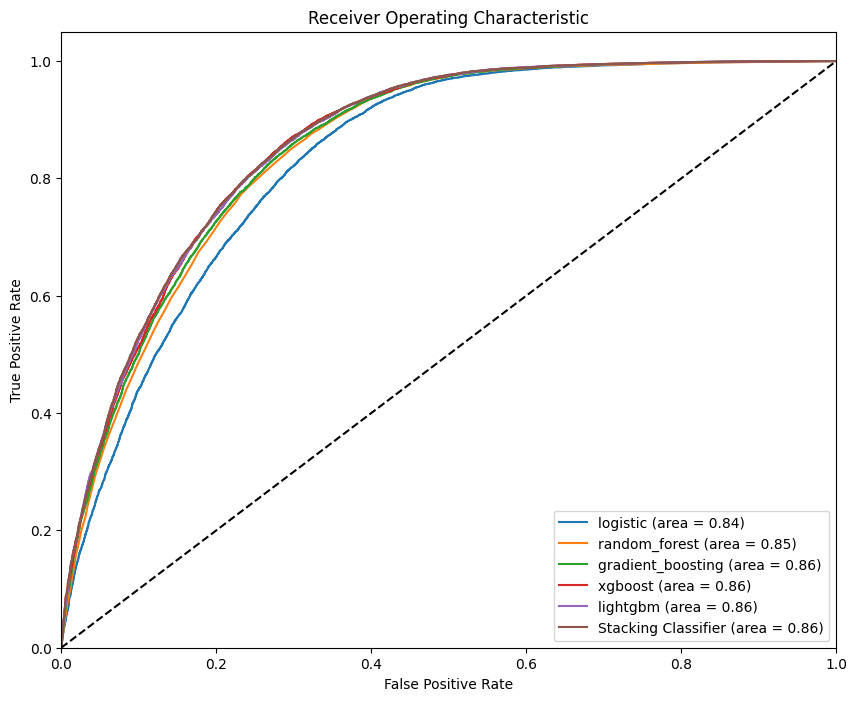

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [32]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from interpret.glassbox import ExplainableBoostingClassifier

# Define base models
xgb = XGBClassifier(learning_rate=0.5, max_depth=3, min_child_weight=12, n_estimators=100, subsample=1.0)
cb = CatBoostClassifier(iterations=1000, learning_rate=0.02, depth=10, loss_function='Logloss', eval_metric='AUC', verbose=200, task_type='CPU')  # Use CPU
lgb = LGBMClassifier(min_child_weight=1, reg_alpha=1.0, subsample=1.0, device='gpu', learning_rate=0.2, colsample_bytree=0.9, objective='binary', max_depth=-1)
rf = RandomForestClassifier(n_estimators=100)
gb = GradientBoostingClassifier(n_estimators=100)
ebc = ExplainableBoostingClassifier()

# Define stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('cb', cb),
        ('lgb', lgb),
        ('rf', rf),
        ('gb', gb),
        ('ebc', ebc)
    ],
    final_estimator=LogisticRegression()
)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate the model
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, stacking_clf.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}, F1 Score: {f1}, ROC AUC: {roc_auc}')


0:	total: 95.7ms	remaining: 1m 35s
200:	total: 10.2s	remaining: 40.5s
400:	total: 19.5s	remaining: 29.1s
600:	total: 30.4s	remaining: 20.2s
800:	total: 43s	remaining: 10.7s
999:	total: 53.4s	remaining: 0us
[LightGBM] [Info] Number of positive: 411, number of negative: 389
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 20
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 620, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 20 dense feature groups (0.02 MB) transferred to GPU in 0.002393 secs. 0 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.513750 -> initscore=0.055014
[LightGBM] [Info] Start training from score 0.055014
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Info] Number of positive: 55584, number of negative: 71820
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2590
[LightGBM] [Info] Number of data points in the train set: 127404, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436281 -> initscore=-0.256268
[LightGBM] [Info] Start training from score -0.256268
[LightGBM] [Info] Number of positive: 44467, number of negative: 57456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 101923, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436280 -> initscore=-0.256272


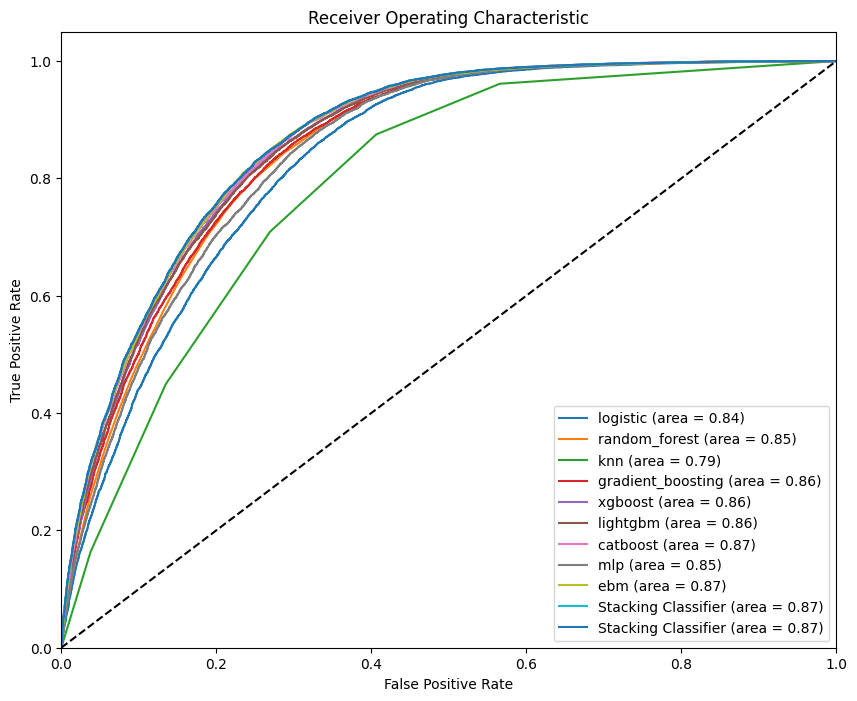

In [7]:
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the roc_data dictionary to store the ROC curve data for each model
roc_data = {}

# Function to calculate and store ROC data for a model
def get_roc_data(model, X_val_scaled, y_val, name):
    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation data using the same scaler
X_val_scaled = scaler.transform(X_val)

# Define the base models for stacking
base_models = [
    ('logistic', LogisticRegression(max_iter=1000)),
    ('random_forest', RandomForestClassifier()),
    ('knn', KNeighborsClassifier()),
    ('gradient_boosting', GradientBoostingClassifier()),
    ('xgboost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lightgbm', lgb.LGBMClassifier()),
    ('catboost', cb.CatBoostClassifier(verbose=0)),
    ('mlp', MLPClassifier(max_iter=1000)),
    ('ebm', ExplainableBoostingClassifier())
]

# Define the final model
final_model = LogisticRegression(max_iter=1000)

# Initialize the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=final_model,
    cv=5 

# Train the stacking classifier with scaled data
stacking_clf.fit(X_train_scaled, y_train)

# Evaluate the stacking classifier
y_pred = stacking_clf.predict(X_val_scaled)
y_proba = stacking_clf.predict_proba(X_val_scaled)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_proba)

print(f"Stacking Classifier - Accuracy: {accuracy}, F1 Score: {f1}, ROC AUC: {roc_auc}")

# Calculate ROC data for each base model
for name, model in base_models:
    model.fit(X_train_scaled, y_train)  # Ensure each base model is fitted
    get_roc_data(model, X_val_scaled, y_val, name)

# Calculate ROC data for the stacking classifier
get_roc_data(stacking_clf, X_val_scaled, y_val, 'Stacking Classifier')

# Add Stacking Classifier to ROC plot
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

# Plot Stacking Classifier ROC curve
plt.plot(fpr, tpr, label=f'Stacking Classifier (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Info] Number of positive: 44467, number of negative: 57456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2559
[LightGBM] [Info] Number of data points in the train set: 101923, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436280 -> initscore=-0.256272
[LightGBM] [Info] Start training from score -0.256272
[LightGBM] [Info] Number of positive: 35573, number of negative: 45965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2517
[LightGBM] [Info] Number of data points in the train set: 81538, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436275 -> initscore=-0.256293
[

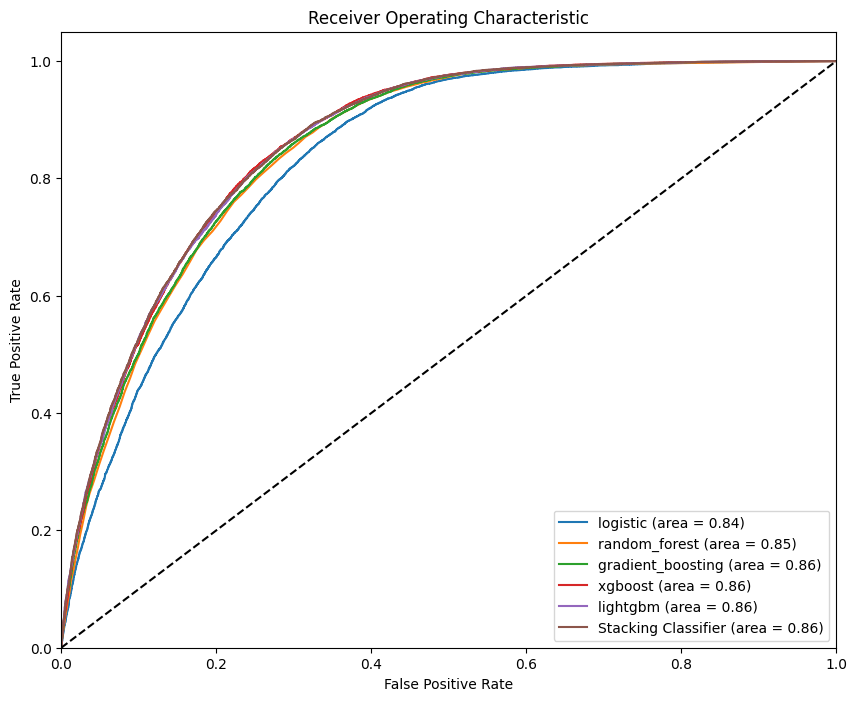

In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the roc_data dictionary to store the ROC curve data for each model
roc_data = {}

# Function to calculate and store ROC data for a model
def get_roc_data(model, X_val_scaled, y_val, name):
    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation data using the same scaler
X_val_scaled = scaler.transform(X_val)

# Define the base models for stacking
base_models = [
    ('logistic', LogisticRegression(max_iter=1000)),
    ('random_forest', RandomForestClassifier()),
    ('gradient_boosting', GradientBoostingClassifier()),
    ('xgboost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lightgbm', lgb.LGBMClassifier())
]

# Define the final model
final_model = LogisticRegression(max_iter=1000)

# Initialize the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=final_model,
    cv=5
)

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Lists to store scores
accuracy_scores = []
f1_scores = []
roc_auc_scores = []

# Perform cross-validation
for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the stacking classifier with scaled data
    stacking_clf.fit(X_train_fold, y_train_fold)

    # Evaluate the stacking classifier
    y_pred = stacking_clf.predict(X_val_fold)
    y_proba = stacking_clf.predict_proba(X_val_fold)[:, 1]

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
    f1_scores.append(f1_score(y_val_fold, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val_fold, y_proba))

# Print the average scores
print(f"Stacking Classifier - Accuracy: {np.mean(accuracy_scores)}, F1 Score: {np.mean(f1_scores)}, ROC AUC: {np.mean(roc_auc_scores)}")

# Calculate ROC data for each base model
for name, model in base_models:
    model.fit(X_train_scaled, y_train)  # Ensure each base model is fitted
    get_roc_data(model, X_val_scaled, y_val, name)

# Calculate ROC data for the stacking classifier
get_roc_data(stacking_clf, X_val_scaled, y_val, 'Stacking Classifier')

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Info] Number of positive: 44467, number of negative: 57456
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2304
[LightGBM] [Info] Number of data points in the train set: 101923, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436280 -> initscore=-0.256272
[LightGBM] [Info] Start training from score -0.256272
[LightGBM] [Info] Number of positive: 35573, number of negative: 45965
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2262
[LightGBM] [Info] Number of data points in the train set: 81538, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.436275 -> initscore=-0.256293
[LightGBM] [Info] Start training from score -0.256293
[LightGBM] 

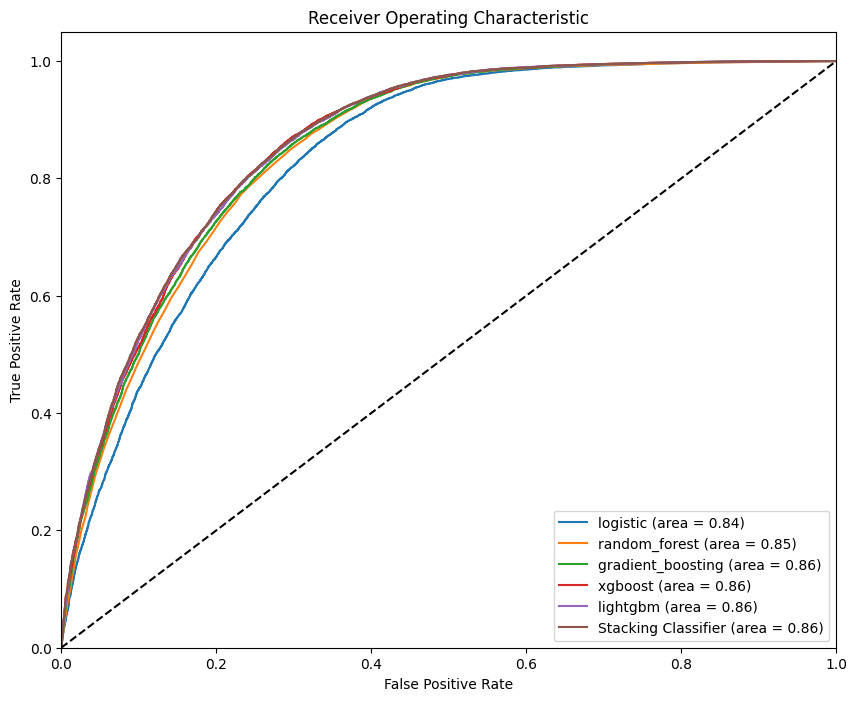

In [40]:
import pandas as pd
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the roc_data dictionary to store the ROC curve data for each model
roc_data = {}

# Function to calculate and store ROC data for a model
def get_roc_data(model, X_val_scaled, y_val, name):
    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation data using the same scaler
X_val_scaled = scaler.transform(X_val)

# Define the base models for stacking
base_models = [
    ('logistic', LogisticRegression(max_iter=1000)),
    ('random_forest', RandomForestClassifier()),
    ('gradient_boosting', GradientBoostingClassifier()),
    ('xgboost', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('lightgbm', lgb.LGBMClassifier())
]

# Define the final model
final_model = LogisticRegression(max_iter=1000)

# Initialize the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=final_model,
    cv=5
)

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5)

# Lists to store scores
accuracy_scores = []
f1_scores = []
roc_auc_scores = []

# Perform cross-validation
for train_idx, val_idx in cv.split(X_train_scaled, y_train):
    X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the stacking classifier with scaled data
    stacking_clf.fit(X_train_fold, y_train_fold)

    # Evaluate the stacking classifier
    y_pred = stacking_clf.predict(X_val_fold)
    y_proba = stacking_clf.predict_proba(X_val_fold)[:, 1]

    # Calculate metrics
    accuracy_scores.append(accuracy_score(y_val_fold, y_pred))
    f1_scores.append(f1_score(y_val_fold, y_pred))
    roc_auc_scores.append(roc_auc_score(y_val_fold, y_proba))

# Print the average scores
print(f"Stacking Classifier - Accuracy: {np.mean(accuracy_scores)}, F1 Score: {np.mean(f1_scores)}, ROC AUC: {np.mean(roc_auc_scores)}")

# Calculate ROC data for each base model
for name, model in base_models:
    model.fit(X_train_scaled, y_train)  # Ensure each base model is fitted
    get_roc_data(model, X_val_scaled, y_val, name)

# Calculate ROC data for the stacking classifier
get_roc_data(stacking_clf, X_val_scaled, y_val, 'Stacking Classifier')

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [44]:
import lime
import lime.lime_tabular

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    mode='classification',
    feature_names=X_train.columns.tolist(),  # Adjust based on your feature names
    class_names=['0', '1'],  # Adjust based on your target classes
    discretize_continuous=True
)

# Select an instance to explain (e.g., the first instance in the validation set)
instance_idx = 0
instance = X_val_scaled[instance_idx]

# Generate explanation
exp = explainer.explain_instance(
    data_row=instance,
    predict_fn=stacking_clf.predict_proba
)

# Show the explanation
exp.show_in_notebook(show_table=True, show_all=False)


In [48]:
import lime.lime_tabular

# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    mode='classification',
    feature_names=expected_columns,
    class_names=['0', '1'],
    discretize_continuous=True
)

# Function to generate and display LIME explanation for a specific model and instance
def explain_instance_with_lime(model, instance_idx, instance, explainer, model_name):
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=model.predict_proba
    )
    print(f"LIME Explanation for {model_name}:")
    exp.show_in_notebook(show_table=True, show_all=False)

# Example usage: Explain an instance for the stacking classifier
instance_idx = 0
instance = X_val_scaled[instance_idx]
explain_instance_with_lime(stacking_clf, instance_idx, instance, explainer, "Stacking Classifier")


LIME Explanation for Stacking Classifier:
